In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_and_prepare_data():
    """Load and prepare training data with proper class distribution analysis"""
    print("📁 Loading training dataset...")
    
    # Load training data
    df = pd.read_csv("training_dataset.csv")
    df["label"] = df["intent"].apply(lambda x: 1 if x.strip().lower() == "people" else 0)
    
    # Check class distribution
    print("\n📊 Class distribution analysis:")
    print(df["label"].value_counts())
    print(f"Class balance: {df['label'].mean():.2%} positive class")
    
    # Split with stratification to ensure balanced train/test sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df["query"].tolist(), 
        df["label"].tolist(), 
        test_size=0.2, 
        random_state=42,
        stratify=df["label"].tolist()
    )
    
    print(f"✅ Data split complete: {len(train_texts)} training, {len(val_texts)} validation samples")
    
    return train_texts, val_texts, train_labels, val_labels


In [3]:
class QueryDataset(Dataset):
    """Custom dataset for BERT input formatting"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(float(self.labels[idx]), dtype=torch.float)
        return item


In [4]:
def freeze_bert_layers(model):
    """
    Freeze BERT layers except last 2 encoder layers and classifier head
    This reduces training time while maintaining model performance
    """
    print("\n🔧 Applying layer freezing strategy...")
    
    for param in model.bert.parameters():
        param.requires_grad = False
    
    num_layers = len(model.bert.encoder.layer)
    for layer in model.bert.encoder.layer[-2:]:
        for param in layer.parameters():
            param.requires_grad = True
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"🔒 Frozen layers: {num_layers - 2} encoder layers + embeddings")
    print(f"🔓 Trainable layers: Last 2 encoder layers + classifier head")
    print(f"📊 Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.1%})")
    
    return model


In [5]:
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1-score for evaluation"""
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits.flatten())) > 0.6).int().numpy()
    labels = labels.astype(int)
    
    acc = accuracy_score(labels, predictions)
    
    if len(np.unique(predictions)) == 1:
        print(f"⚠️  Warning: All predictions are class {predictions[0]}")
        if predictions[0] == 1:
            precision, recall, f1 = 1.0, acc, 2*acc/(1+acc) if acc > 0 else 0.0
        else:
            precision, recall, f1 = 0.0, 0.0, 0.0
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [6]:
class CustomTrainer(Trainer):
    """Custom trainer with BCE loss for binary classification"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        logits = logits.view(-1)
        labels = labels.view(-1)
        
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        
        if num_items_in_batch is not None:
            loss = loss * num_items_in_batch / len(labels)
        
        return (loss, outputs) if return_outputs else loss


In [7]:
def test_on_dataset(model, tokenizer, csv_file, output_file, description=""):
    """Test model on a given dataset and save results"""
    print(f"\n🧪 Testing model on {csv_file}...")
    
    df = pd.read_csv(csv_file)
    queries = df["query"].tolist()
    true_labels = [1 if lbl.strip().lower() == "people" else 0 for lbl in df["intent"].tolist()]
    
    pred_labels = []
    pred_probs = []
    device = torch.device("cpu")
    
    for query in queries:
        inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            prob = torch.sigmoid(outputs.logits).item()
            pred_label = 1 if prob > 0.6 else 0
        
        pred_labels.append(pred_label)
        pred_probs.append(prob)
    
    acc = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")
    
    print(f"📊 {description} Results:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    results_df = pd.DataFrame({
        "query": queries,
        "true_intent": ["people" if l == 1 else "search" for l in true_labels],
        "predicted_intent": ["people" if p == 1 else "search" for p in pred_labels],
        "probability": [round(p, 3) for p in pred_probs],
        "correct": [1 if pred_labels[i] == true_labels[i] else 0 for i in range(len(pred_labels))]
    })
    
    results_df.to_csv(output_file, index=False)
    print(f"✅ Results saved to {output_file}")
    
    return acc, precision, recall, f1


In [8]:
def test_on_validation_split(model, tokenizer, train_texts, val_texts, train_labels, val_labels):
    """Test model on the validation split from training data"""
    print(f"\n🔬 Testing on validation split (20% of training data)...")
    
    pred_labels = []
    pred_probs = []
    device = torch.device("cpu")
    
    for query in val_texts:
        inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            prob = torch.sigmoid(outputs.logits).item()
            pred_label = 1 if prob > 0.6 else 0
        
        pred_labels.append(pred_label)
        pred_probs.append(prob)
    
    acc = accuracy_score(val_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, pred_labels, average="binary")
    
    print(f"📊 Validation Split Results:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    val_df = pd.DataFrame({
        "query": val_texts,
        "true_intent": ["people" if l == 1 else "search" for l in val_labels],
        "predicted_intent": ["people" if p == 1 else "search" for p in pred_labels],
        "probability": pred_probs
    })
    
    val_df.to_csv("validation_results.csv", index=False)
    print("✅ Validation results saved to validation_results.csv")
    
    return acc, precision, recall, f1


In [9]:
"""Main execution pipeline"""
print("🚀 Starting BERT Intent Classification Pipeline\n")
    
train_texts, val_texts, train_labels, val_labels = load_and_prepare_data()
    
print("\n🔤 Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)
    
train_dataset = QueryDataset(train_encodings, train_labels)
val_dataset = QueryDataset(val_encodings, val_labels)
    
print("\n🤖 Initializing BERT model...")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=1,
    problem_type="single_label_classification"
)

🚀 Starting BERT Intent Classification Pipeline

📁 Loading training dataset...

📊 Class distribution analysis:
label
1    1086
0     828
Name: count, dtype: int64
Class balance: 56.74% positive class
✅ Data split complete: 1531 training, 383 validation samples

🔤 Initializing BERT tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🤖 Initializing BERT model...


In [10]:
model = freeze_bert_layers(model)


🔧 Applying layer freezing strategy...
🔒 Frozen layers: 10 encoder layers + embeddings
🔓 Trainable layers: Last 2 encoder layers + classifier head
📊 Trainable parameters: 14,176,513 / 109,483,009 (12.9%)


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=100,
    report_to=None
)

In [12]:
print("\n🎯 Setting up trainer...")
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/dz/ljw9ygcd3sz2n1nrcxs9dywh0000gq/T/ipykernel_48791/3635768468.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(



🎯 Setting up trainer...


In [13]:
print("\n🏋️‍♂️ Starting model training...")
trainer.train()


🏋️‍♂️ Starting model training...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.306400,0.097909,0.986945,1.000000,0.976959,0.988345
200,0.065400,0.035772,0.992167,1.000000,0.986175,0.993039


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=288, training_loss=0.20616060785121387, metrics={'train_runtime': 26.2981, 'train_samples_per_second': 174.651, 'train_steps_per_second': 10.951, 'total_flos': 77888909156454.0, 'train_loss': 0.20616060785121387, 'epoch': 3.0})

In [14]:
print("\n📈 Evaluating trained model...")
eval_results = trainer.evaluate()
print("Final evaluation results:", eval_results)


📈 Evaluating trained model...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final evaluation results: {'eval_loss': 0.035772357136011124, 'eval_accuracy': 0.9921671018276762, 'eval_precision': 1.0, 'eval_recall': 0.9861751152073732, 'eval_f1': 0.9930394431554525, 'eval_runtime': 1.3072, 'eval_samples_per_second': 292.992, 'eval_steps_per_second': 18.36, 'epoch': 3.0}


In [15]:
predictions = trainer.predict(val_dataset)
pred_probs = torch.sigmoid(torch.tensor(predictions.predictions.flatten()))
pred_labels = (pred_probs > 0.5).int().numpy()
print("\n📊 Prediction distribution:")
print(pd.Series(pred_labels).value_counts())
print(f"Prediction probabilities - Mean: {pred_probs.mean():.3f}, Std: {pred_probs.std():.3f}")
print(f"Min prob: {pred_probs.min():.3f}, Max prob: {pred_probs.max():.3f}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Prediction distribution:
1    214
0    169
Name: count, dtype: int64
Prediction probabilities - Mean: 0.559, Std: 0.484
Min prob: 0.010, Max prob: 0.992


In [16]:
print("\n💾 Saving trained model...")
model.save_pretrained("bert_intent_classifier")
tokenizer.save_pretrained("bert_intent_classifier")
print("✅ Model and tokenizer saved to 'bert_intent_classifier' directory")



💾 Saving trained model...
✅ Model and tokenizer saved to 'bert_intent_classifier' directory


In [17]:
print("\n🔄 Reloading model for testing...")
model_path = "bert_intent_classifier"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()


🔄 Reloading model for testing...


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
try:
    test_on_dataset(
        model, tokenizer, 
        "testing_dataset.csv", 
        "external_test_results.csv",
        "External Test Dataset"
    )
except FileNotFoundError:
    print("⚠️  testing_dataset.csv not found. Skipping external test.")


🧪 Testing model on testing_dataset.csv...
📊 External Test Dataset Results:
Accuracy : 0.9518
Precision: 0.8266
Recall   : 0.8773
F1-score : 0.8512
✅ Results saved to external_test_results.csv


In [20]:
test_on_validation_split(model, tokenizer, train_texts, val_texts, train_labels, val_labels)
    
print("\n🎉 Pipeline completed successfully!")
print("\nGenerated files:")
print("- bert_intent_classifier/ (trained model)")
print("- external_test_results.csv (if testing_dataset.csv exists)")
print("- validation_results.csv (validation split results)")


🔬 Testing on validation split (20% of training data)...
📊 Validation Split Results:
Accuracy : 0.9922
Precision: 1.0000
Recall   : 0.9862
F1-score : 0.9930
✅ Validation results saved to validation_results.csv

🎉 Pipeline completed successfully!

Generated files:
- bert_intent_classifier/ (trained model)
- external_test_results.csv (if testing_dataset.csv exists)
- validation_results.csv (validation split results)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


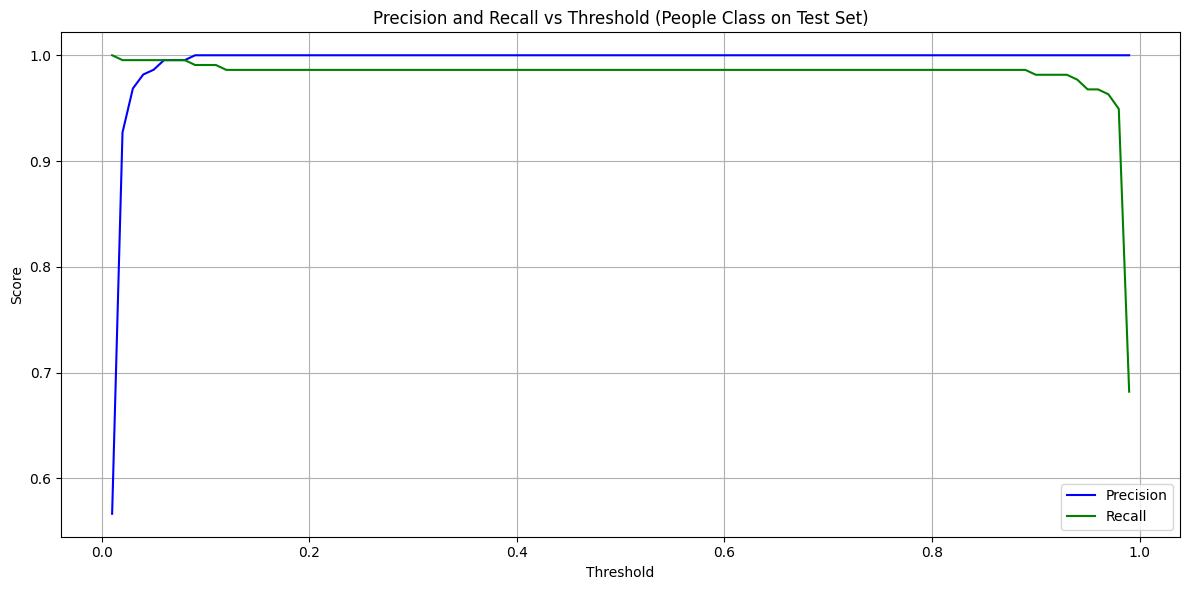

In [21]:

predictions = trainer.predict(val_dataset)
y_true = np.array(val_labels)  # already 0 for search, 1 for people
y_prob = torch.sigmoid(torch.tensor(predictions.predictions.flatten())).numpy()

thresholds = np.arange(0.01, 1.0, 0.01)
precision_vals, recall_vals = [], []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precision_vals.append(precision_score(y_true, y_pred, zero_division=0))
    recall_vals.append(recall_score(y_true, y_pred, zero_division=0))

plt.figure(figsize=(12,6))
plt.plot(thresholds, precision_vals, label="Precision", color="blue")
plt.plot(thresholds, recall_vals, label="Recall", color="green")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold (People Class on Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


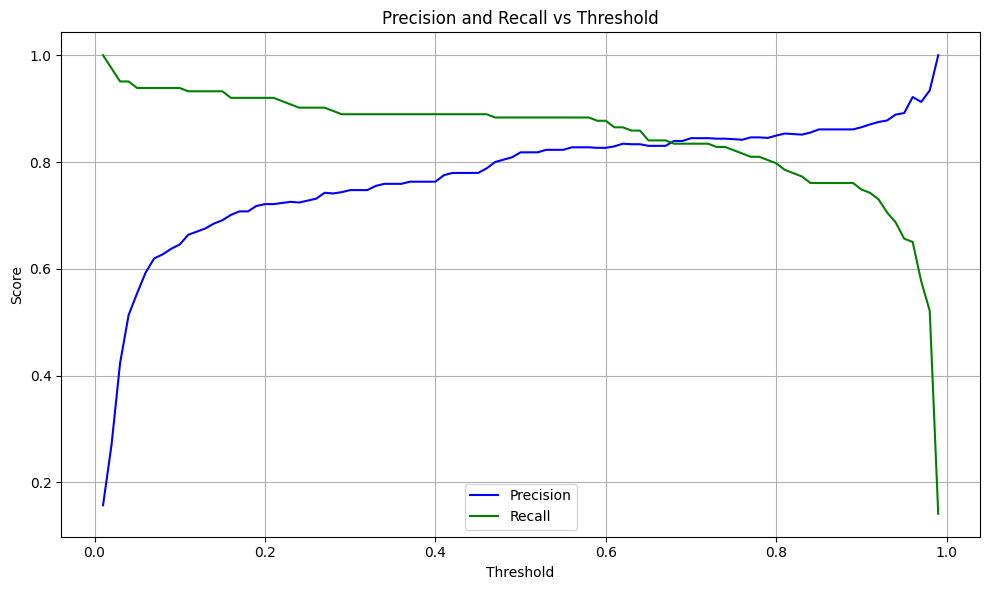

In [22]:
df = pd.read_csv("external_test_results.csv")

# Convert ground truth intent into binary (1=people, 0=search)
y_true = df["true_intent"].apply(lambda x: 1 if x.strip().lower() == "people" else 0).values
y_prob = df["probability"].values  # already saved as float in test1.csv


thresholds = np.arange(0.01, 1.0, 0.01)
precision_vals, recall_vals = [], []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precision_vals.append(precision_score(y_true, y_pred, zero_division=0))
    recall_vals.append(recall_score(y_true, y_pred, zero_division=0))


plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_vals, label="Precision", color="blue")
plt.plot(thresholds, recall_vals, label="Recall", color="green")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
